In [4]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import math as mt
from math import e
import datetime
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from random import seed
from random import randint
from scipy.signal import hilbert
import statistics
from scipy.stats import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import pickle
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from time import time
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

# Input Fog Data 

In [5]:
fogData = xr.open_dataset('../../../Data/FogData/CombinedFogData_25Stations.nc')
fogData = xr.open_dataset('../../../Data/FogData/CombinedFogData_25Stations.nc')
#plt.figure(figsize=[16,8])
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
y=fg.fogdata.sum(dim='stations').sel(time=slice('1980-1-1','2014-12-31'))
y=y/25.0
#y

# ERA5 Input



In [6]:
#Surface data
t2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_t2m_daily_NovDecJan.nc')
d2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_d2m_daily_NovDecJan.nc')
u10Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_u10_daily_NovDecJan.nc')
v10Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_v10_daily_NovDecJan.nc')
# 850 Data
tuv850Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_uvt_daily_NovDecJan.nc')
z850Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_z_daily_NovDecJan.nc')
#700 Data
w700Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_700_w_daily_NovDecJan.nc')
# Read Orography
OroData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5IGP_Orography.nc')

In [7]:
t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86))
u10D = u10Data.sel(latitude=slice(32,24),longitude=slice(74,86))
v10D = v10Data.sel(latitude=slice(32,24),longitude=slice(74,86))
d2mD = d2mData.sel(latitude=slice(32,24),longitude=slice(74,86))
tuv850D = tuv850Data.sel(latitude=slice(32,24),longitude=slice(74,86))
z850D = z850Data.sel(latitude=slice(32,24),longitude=slice(74,86))
w700D = w700Data.sel(latitude=slice(32,24),longitude=slice(74,86))
OroD = OroData.sel(latitude=slice(32,24),longitude=slice(74,86))

In [8]:
# Calculate wind speed and relative humidity
ws = ((v10D.v10.values**2)+(u10D.u10.values**2))**0.5
ws_ds = xr.Dataset({'ws': (('time','latitude','longitude'), ws)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})
rh = (e**((17.625*(d2mD.d2m.values-273.15))/(243.04+(d2mD.d2m.values-273.15)))/e**((17.625*(t2mD.t2m.values-273.15))/(243.04+(t2mD.t2m.values-273.15))))
rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rh)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})
#Calculate inv
inv=t2mD.t2m.values-tuv850D.t.values
inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})
inv_ds.attrs
inv_ds.attrs['units']='K'
inv_ds.attrs['long_name']='t2m - t850'

In [9]:
#u shear calculation
ushear=(tuv850D.u.values-u10D.u10.values)/(z850D.z.values/9.81) 
ushear_ds = xr.Dataset({'ushear': (('time','latitude','longitude'), ushear)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})
ushear_ds.attrs['units']='s-1'
ushear_ds.attrs['long_name']='(u10 - u850)/z850'


In [10]:
# create mask
oro = OroD.z
oro.values = OroD.z.values/9.81
oro.attrs
oro.attrs['units']='meter'
oro.attrs['long_name']='Orography'
oro.values[oro.values>500.1]=np.NaN
mask=oro.values/oro.values
# Chk mask
#t2mD.t2m.values=t2mD.t2m.values*mask
#t2mD.t2m[0,:,:].plot(cmap='jet')

In [11]:
# Apply Mask 
t2mD.t2m.values=t2mD.t2m.values*mask
ws_ds.ws.values=ws_ds.ws.values*mask
rh_ds.rh.values=rh_ds.rh.values*mask
w700D.w.values=w700D.w.values*mask
inv_ds.inv.values=inv_ds.inv.values*mask
ushear_ds.ushear.values=ushear_ds.ushear.values*mask

In [12]:
# Feild mean
t2mTS1=t2mD.mean(dim=['latitude','longitude'], skipna=True).t2m
wsTS1=ws_ds.mean(dim=['latitude','longitude'], skipna=True).ws
rhTS1=rh_ds.mean(dim=['latitude','longitude'], skipna=True).rh
wTS1=w700D.mean(dim=['latitude','longitude'], skipna=True).w
invTS1=inv_ds.mean(dim=['latitude','longitude'], skipna=True).inv
ushearTS1=ushear_ds.mean(dim=['latitude','longitude'], skipna=True).ushear

In [13]:
# shift one day so we can take values of previous day
t2mTS=t2mTS1.shift(time=1)
wsTS=wsTS1.shift(time=1)
rhTS=rhTS1.shift(time=1)
wTS=wTS1.shift(time=1)
invTS=invTS1.shift(time=1)
ushearTS=ushearTS1.shift(time=1)

In [14]:
# Select required time 
t2m=t2mTS[((t2mTS.time.dt.month>11) | (t2mTS.time.dt.month<2)) & (t2mTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'))
ws=wsTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'))
inv=invTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'))
rh=rhTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'))
w=wTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'))
ushear=ushearTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'))

In [15]:
# input X
X       = pd.DataFrame([t2m.values,ws.values,rh.values,inv.values,w.values,ushear.values*100.0]).T[:]
#X       = pd.DataFrame([ws.values,rh.values,inv.values,w.values]).T[:]
X.index = pd.to_datetime(t2m.time.values)
X

,0,1,2,3,4,5
1980-01-01 09:00:00,289.120636,1.737170,0.681204,5.449228,-0.103194,0.353420
1980-01-02 09:00:00,288.971771,2.071385,0.743338,5.749483,-0.125205,0.273085
1980-01-03 09:00:00,288.303253,1.375861,0.758891,6.781636,-0.049128,0.160400
1980-01-04 09:00:00,287.083527,1.883535,0.746639,6.586329,0.070247,0.053234
1980-01-05 09:00:00,286.249054,1.991354,0.709822,5.626440,0.038802,0.038249
...,...,...,...,...,...,...
2014-12-27 09:00:00,286.107513,2.259315,0.695095,2.767421,0.122140,0.157532
2014-12-28 09:00:00,285.829620,1.387228,0.669559,2.802088,0.080767,0.101353
2014-12-29 09:00:00,285.367218,1.404445,0.691786,1.201003,0.032552,-0.067379
2014-12-30 09:00:00,285.100342,1.548697,0.727608,0.743486,-0.013434,-0.084967


In [16]:
norm = StandardScaler().fit(X)
    # transform training data
X = norm.transform(X)
X

array([[ 0.08478527,  0.11248646,  0.6274767 ,  0.84882076, -2.15144912,
         1.74433235],
       [ 0.00633467,  0.99728945,  1.41436304,  1.01606255, -2.48173371,
         0.98799211],
       [-0.34596934, -0.84404145,  1.61134034,  1.59097161, -1.34017904,
        -0.07290252],
       ...,
       [-1.89323784, -0.76836812,  0.76148799, -1.51743825, -0.11455209,
        -2.21738921],
       [-2.03387961, -0.38647531,  1.2151491 , -1.77227492, -0.8045745 ,
        -2.38298056],
       [-2.05983682, -0.24962202,  1.67381266, -1.60062337, -1.64730029,
        -2.43203797]])

# Gradient Boosting Parameter Tuning

Accuracy of base Gradient Boosting model is , 0.735187051028512


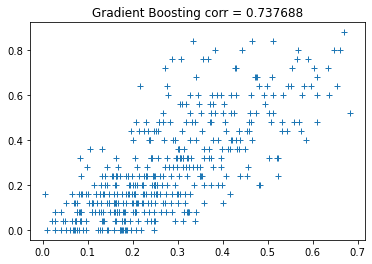

In [17]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)
regressor = GradientBoostingRegressor(random_state=0,learning_rate= 0.01,max_depth= 2, min_samples_leaf= 15, n_estimators=1000)
regressor.fit(X_train, y_train)
acc_svr       = round(regressor.score(X_test, y_test) * 100, 2)
print("Accuracy of base Gradient Boosting model is ,",(acc_svr/100)**0.5)
yy_test = regressor.predict(X_test)
test_corr = np.corrcoef(yy_test,y_test)[0,1]
plt.title('Gradient Boosting corr = %f'%test_corr)
plt.plot(yy_test,y_test,'+')

# SVR Parameter Tuning 

In [24]:
svReg = SVR()


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
#=20, max_depth= 3,learning_rate=0.04,
param_dist = {'kernel':[ 'rbf','poly' ,'sigmoid'  ],
              'gamma': ['scale', 'auto'],
              'C': [1,2,3,4,5,6],
              'epsilon':[0.1,0.05,0.15,0.2,0.25],
              }

# run grid search
grid_search = GridSearchCV(svReg, param_grid=param_dist,scoring='r2',cv=5)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 309.33 seconds for 180 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.189 (std: 0.302)
Parameters: {'C': 1, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'rbf'}

Model with rank: 2
Mean validation score: 0.187 (std: 0.305)
Parameters: {'C': 1, 'epsilon': 0.05, 'gamma': 'auto', 'kernel': 'rbf'}

Model with rank: 3
Mean validation score: 0.185 (std: 0.389)
Parameters: {'C': 1, 'epsilon': 0.15, 'gamma': 'scale', 'kernel': 'rbf'}



Accuracy of base SVR model is , 0.7285602240034793


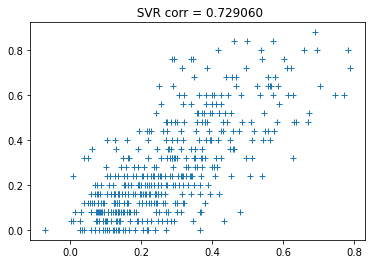

In [19]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)
regressor = SVR(C= 3, gamma='auto', kernel= 'rbf')
regressor.fit(X_train, y_train)
acc_svr       = round(regressor.score(X_test, y_test) * 100, 2)
print("Accuracy of base SVR model is ,",(acc_svr/100)**0.5)
yy_test = regressor.predict(X_test)
test_corr = np.corrcoef(yy_test,y_test)[0,1]
plt.title(' SVR corr = %f'%test_corr)
plt.plot(yy_test,y_test,'+')

Accuracy of base SVR model is , 0.7390534486760751


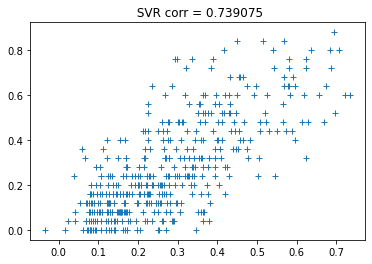

In [23]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)
regressor = SVR(C= 1, gamma='scale', kernel= 'rbf')
regressor.fit(X_train, y_train)
acc_svr       = round(regressor.score(X_test, y_test) * 100, 2)
print("Accuracy of base SVR model is ,",(acc_svr/100)**0.5)
yy_test = regressor.predict(X_test)
test_corr = np.corrcoef(yy_test,y_test)[0,1]
plt.title(' SVR corr = %f'%test_corr)
plt.plot(yy_test,y_test,'+')

Accuracy of base SVR model is , 0.7330757123244501


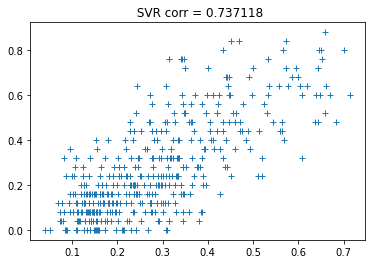

In [27]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)
regressor = SVR(C= 1, gamma='scale', kernel= 'rbf',epsilon=0.15)
regressor.fit(X_train, y_train)
acc_svr       = round(regressor.score(X_test, y_test) * 100, 2)
print("Accuracy of base SVR model is ,",(acc_svr/100)**0.5)
yy_test = regressor.predict(X_test)
test_corr = np.corrcoef(yy_test,y_test)[0,1]
plt.title(' SVR corr = %f'%test_corr)
plt.plot(yy_test,y_test,'+')

# Linear Regression

Accuracy of base Linear Regression model is , 0.7158212067269312


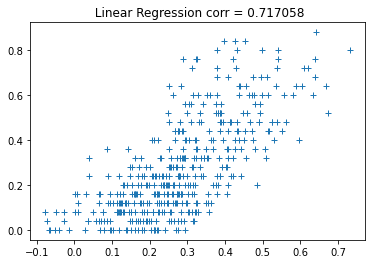

In [20]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)
regLin=LinearRegression().fit(X_train, y_train)
acc_svr       = round(regLin.score(X_test, y_test) * 100, 2)
print("Accuracy of base Linear Regression model is ,",(acc_svr/100)**0.5)
yy_test = regLin.predict(X_test)
test_corr = np.corrcoef(yy_test,y_test)[0,1]
plt.title(' Linear Regression corr = %f'%test_corr)
plt.plot(yy_test,y_test,'+')

# Extreme Gradient Boosting

Accuracy of XGB model is , 0.7420916385460761


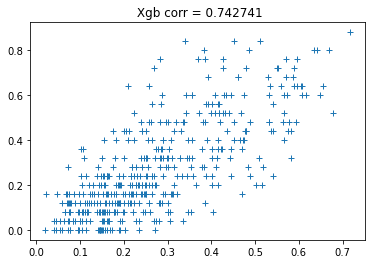

In [21]:
# define the model
model = XGBRegressor(n_estimators=100,learning_rate=0.05,max_depth=5,objective ='reg:squarederror' )
model.fit(X_train, y_train.values)
acc_svr       = round(model.score(X_test, y_test) * 100, 2)
print("Accuracy of XGB model is ,",(acc_svr/100)**0.5)
yy_test = model.predict(X_test)
test_corr = np.corrcoef(yy_test,y_test)[0,1]
plt.title(' Xgb corr = %f'%test_corr)
plt.plot(yy_test,y_test,'+')